## Reflected Ornstein-Uhlenbeck (ROU) process

- SDE numerical simulation
- Expected time to reach a level
- Fokker-Plank equation: Chang-Cooper scheme
- Stationary Fokker-Plank
- MLE parameter estimation

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as scp
import scipy.stats as ss
from scipy import sparse
from scipy.sparse.linalg import spsolve

### ROU SDE

The ROU process (see ref [1]) is a basic Ornstein-Uhlenbeck (OU) process (see ref [2]) with a reflection barrier at zero, to prevent negative values.

The ROU process $ X = \{X_t:  0 \leq t \leq T\}$ is formally described by the following stochastic differential equation:

$$
  dX_t = -\kappa X_t dt + \sigma dW_t\ + dL_t,   \quad \text{ with } \quad X_0 = 0,
$$

where: 
- $\kappa$ is the reversion to zero coefficient. 
- $\sigma$ is the diffusion coefficient. 

The process $ W = \{W_t:  0 \leq t \leq T\}$ is a standard Brownian motion and the process $ L = \{L_t:  0 \leq t \leq T\}$ is the minimal non-decreasing process which makes $X_t \geq 0$ for all $t \geq 0$, also known as the local time process. 

### Simulation

In order to simulate the ROU process we need to discretize the time interval $[0,T]$ in $N$ time steps of size $\Delta t$. 
We calculate the value of the discretized ROU process $X_n$ for $n \in \mathbb{N}$ and $n \leq N$ using the recursive relation: 

$$ X_{n+1} = \max \bigl\{ e^{-\kappa \Delta t} X_n + \tilde \sigma \epsilon_n \, , \, 0 \bigr\} $$

where $\tilde \sigma := \sqrt{ \frac{\sigma^2}{2\kappa} (1-e^{-2 \kappa \Delta t}) }$ and $\epsilon_n \sim \mathcal{N}(0,1)$ is a standard Normal random variable.

Let's simulate a few paths.

In [2]:
%%time
np.random.seed(seed=41)

N = 15000  # time steps
paths = 5000  # number of paths
T = 1
T_vec, dt = np.linspace(0, T, N, retstep=True)

kappa = 5
theta = 0  # let's keep a theta, but set to zero
sigma = 4
std_asy = np.sqrt(sigma**2 / (2 * kappa))  # asymptotic std for OU

X0 = 0
X = np.zeros((N, paths))
X[0, :] = X0
std_dt = np.sqrt(sigma**2 / (2 * kappa) * (1 - np.exp(-2 * kappa * dt)))
W = ss.norm.rvs(loc=0, scale=std_dt, size=(N - 1, paths))

exp_ = np.exp(-kappa * dt)
for t in range(0, N - 1):
    X[t + 1, :] = theta + exp_ * (X[t, :] - theta) + W[t, :]
    X[t + 1, :] = np.where(X[t + 1, :] > 0.0, X[t + 1, :], 0.0)

X_T = X[-1, :]  # values of X at time T
X_1 = X[:, 0]  # a single path

CPU times: user 1.22 s, sys: 134 ms, total: 1.36 s
Wall time: 1.39 s


Mean and standard deviation computed at time $T$.

In [3]:
mean = X_T.mean()
std = X_T.std()

print("Mean = {0:.6f}, STD = {1:.6f}".format(mean, std))

Mean = 1.003902, STD = 0.767355


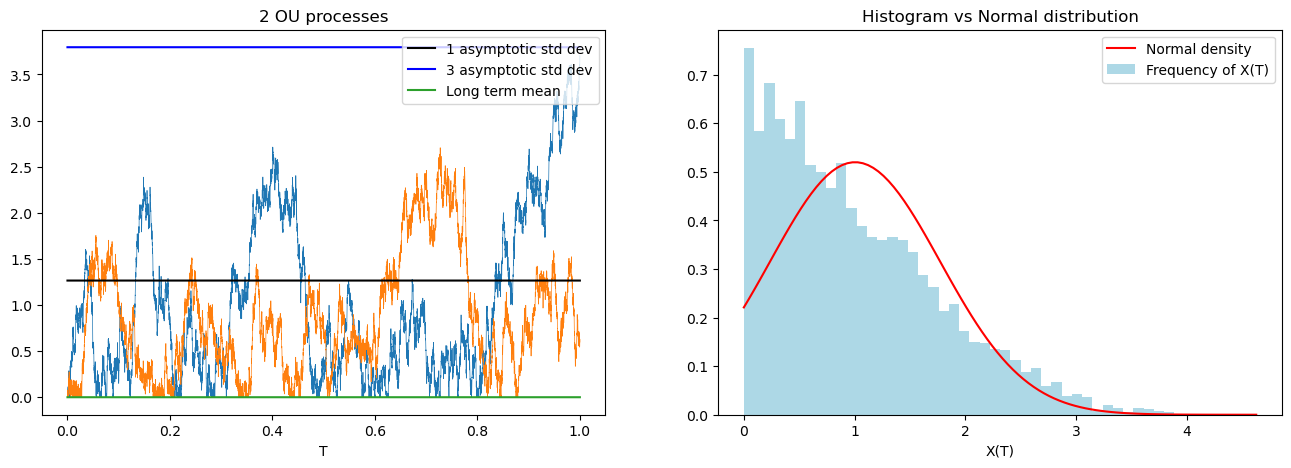

In [4]:
N_processes = 2  # number of processes
x = np.linspace(X_T.min(), X_T.max(), 100)
pdf_fitted = ss.norm.pdf(x, loc=mean, scale=std)

fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(T_vec, X[:, :N_processes], linewidth=0.5)
ax1.plot(T_vec, (theta + std_asy) * np.ones_like(T_vec), label="1 asymptotic std dev", color="black")
ax1.plot(T_vec, (theta + 3 * std_asy) * np.ones_like(T_vec), label="3 asymptotic std dev", color="blue")
ax1.plot(T_vec, theta * np.ones_like(T_vec), label="Long term mean")
ax1.legend(loc="upper right")
ax1.set_title(f"{N_processes} OU processes")
ax1.set_xlabel("T")

ax2.plot(x, pdf_fitted, color="r", label="Normal density")
ax2.hist(X_T, density=True, bins=50, facecolor="LightBlue", label="Frequency of X(T)")
ax2.legend()
ax2.set_title("Histogram vs Normal distribution")
ax2.set_xlabel("X(T)")
plt.show()

##  Expected time to reach a level 


### Monte Carlo approach

Let us compute the expected time to reach 1 std_asy using Monte Carlo.     
Not 3 std_asy!!     
The reason is that most of the time the simulation doesn't touch 3 std_asy, and we don't want to have a zero!  Having a zero means it touches the level at time zero, which is wrong!!

In [5]:
T_to_asy = np.argmax(X >= 1 * std_asy, axis=0) * dt  # first exit time
print("Are there paths that never touch the line?", (T_to_asy == 0).any())
print(f"The expected time is {T_to_asy.mean()} with standard error {ss.sem(T_to_asy)}")

Are there paths that never touch the line? False
The expected time is 0.12473002200146675 with standard error 0.0014402838531263945


### ODE approach

The expected time $U$ is the solution of the following differential equation (see [1]):

$$ - \kappa x \frac{dU}{dx} + \frac{1}{2} \sigma^2 \frac{d^2 U}{dx^2} = -1$$

$$ U'(0) = 0 \quad \text{and} \quad U(x_{max}) = 0 . $$

with mixed boundary conditions.


Here $x_{max} = \frac{\sigma^2}{2 \kappa}$ corresponds to the asymptiotic standard deviation of the OU process. 

#### Discretization

The domain is discretized in the set of points ${x_0, ..., x_N}$.    
This is a boudary value problem, that can be solved by a finite difference method. The discretization scheme is:

$$
          - \kappa x_i \frac{U_{i} - U_{i-1}}{ \Delta x} 
          + \frac{1}{2} \sigma^2  \frac{U_{i+1} + U_{i-1} - 2 U_{i}}{\Delta x^2} 
          + 1  = 0. 
$$

where we discretized the first order derivative with backward discretization $U'(x_i) = \frac{U_i-U_{i-1}}{\Delta x}$.    
It follows that at $x_0 = 0$ the derivative $U'(0) = 0$ implies: 

$$ U_0 = U_{-1}.$$

It also hold that $x_N = x_{max}$, and $U(x_N) := U_N = 0$.      
We can rewrite the equation above as:

$$ 
\underbrace{\biggl( \frac{k x_i}{\Delta x} + \frac{1}{2} 
\frac{\sigma^2}{\Delta x^2} \biggr)}_{a_i} U_{i-1} 
              + \underbrace{\biggl( \frac{-k x_i}{\Delta x} - \frac{\sigma^2}{\Delta x^2} \biggr) }_{b_i} U_{i}
              + \underbrace{\biggl( \frac{1}{2} 
\frac{\sigma^2}{\Delta x^2} \biggr)}_{c_i} U_{i+1} \; = \; -1
$$

for $0 < i < N-1$.    
For $i=0$ (remember that $x_0=0$): 

$$ - \frac{1}{2}\frac{\sigma^2}{\Delta x^2} U_0 + \frac{1}{2}\frac{\sigma^2}{\Delta x^2} U_1  = -1 $$

and for $i=N-1$:

$$ a_{N-1}\, U_{N-2} + b_{N-1} \, U_{N-1} + c_{N-1}\, \underbrace{U_{N}}_{=0} = -1$$

That in matrix form becomes 

$$ \mathcal{D}\, U = -1 $$

where $\mathcal{D}$ is the usual $N \times N$ tridiagonal matrix.  

In [6]:
Nspace = 500000  # space steps
x_max = 1 * std_asy
x_0 = 0
x, dx = np.linspace(x_0, x_max, Nspace, retstep=True)  # space discretization

U = np.zeros(Nspace)  # grid initialization
constant_term = -np.ones(Nspace - 1)  # -1

# construction of the tri-diagonal matrix D
sig2_dx = (sigma * sigma) / (dx * dx)
a = kappa * x[:-1] / dx + 0.5 * sig2_dx
b = -kappa * x[:-1] / dx - sig2_dx
c = 0.5 * sig2_dx * np.ones_like(a)

b[0] = -0.5 * sig2_dx  # term added from BC at x0

aa = a[1:]
cc = c[:-1]  # upper and lower diagonals
D = sparse.diags([aa, b, cc], [-1, 0, 1], shape=(Nspace - 1, Nspace - 1)).tocsc()  # matrix D

U[:-1] = spsolve(D, constant_term)

Text(0, 0.5, 'expected time')

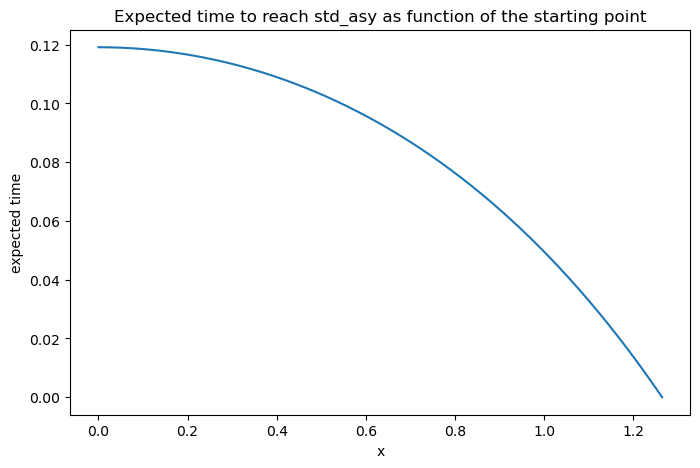

In [7]:
fig = plt.figure(figsize=(8, 5))
plt.title("Expected time to reach std_asy as function of the starting point")
plt.plot(x, U)
plt.xlabel("x")
plt.ylabel("expected time")

In [8]:
print("Expected time to reach 1 std_axy starting from zero: ", U[0])

Expected time to reach 1 std_axy starting from zero:  0.11915005010016264


## Fokker Plank equation

The distribution of $X_t$ can be obtained by solving the [Fokker-Plank](https://en.wikipedia.org/wiki/Fokker%E2%80%93Planck_equation) equation.

$$
\frac{\partial p(t,x)}{\partial t} = \kappa \frac{\partial}{\partial x} \biggl( 
x \, p(t,x) \biggr) + \frac{1}{2} \sigma^2 \frac{\partial^2 p(t,x)}{\partial x^2}
$$

with the following: 
- boundary conditions: 
$$p(t,\infty) = 0, \quad \quad \frac{\partial p(t,x)}{\partial x}\bigg|_{x=0} = 0.$$
- initial conditions:  $$p(0,x) = \delta(x).$$


Let us rewrite 
$$ \frac{\partial}{\partial x} \biggl( 
x \, p(t,x) \biggr) = p(t,x) + x \frac{\partial p(t,x)}{\partial x}.$$ 

### Discretization of the Fokker Plank equation

The following two schemes **do not** work:

1) 
$$ \frac{ p_{i}^{n+1} - p_{i}^{n} }{\Delta t} = \kappa p_{i}^{n+1} +
\kappa x_i \frac{p_{i}^{n+1} - p_{i-1}^{n+1}}{\Delta x}
+ \frac{1}{2} \sigma^2 \frac{p_{i+1}^{n+1} + p_{i-1}^{n+1} -2 p_{i}^{n+1} }{\Delta x^2} $$

2) 
$$ \frac{ p_{i}^{n+1} - p_{i}^{n} }{\Delta t} = \kappa p_{i}^{n+1} +
\kappa x_i \frac{p_{i+1}^{n+1} - p_{i-1}^{n+1}}{2 \Delta x}
+ \frac{1}{2} \sigma^2 \frac{p_{i+1}^{n+1} + p_{i-1}^{n+1} -2 p_{i}^{n+1} }{\Delta x^2} $$

The problem is that the total probability is not conserved. We need to use a scheme that conserve this quantity.

### The Chang Cooper scheme

The Fokker Plank equation can be written as

$$
\frac{\partial p(t,x)}{\partial t} = \frac{\partial}{\partial x} \biggl( 
\underbrace{\kappa x}_{B(x)} \, p(t,x) + \underbrace{\frac{1}{2} \sigma^2}_{C(x)} \frac{\partial}{\partial x} p(t,x) \biggr)
$$

The coefficients $B(x)$ and $C(x)$ are positive.  Thanks to a Theorem in [3] this guarantees that the solution $p(t,x)$ is always positive if $p(0,x)$ is positive.

Let us define the flux

$$ F(t,x) = B(t,x) p(t,x) + C(t,x) \frac{\partial}{\partial x} p(t,x) $$

that satisfies the boundary conditions:

1) $F(t,0) = 0$,  
2) $lim_{x\to \infty}$ F(t,x) = 0. 

The point 1) is because $B(t,0)=0$ and $\frac{\partial}{\partial x} p(t,x) = 0$ at $x=0$.    The point 2) is because $x p(t,x) \to 0$ as $x \to \infty$.     
For large x, $p(t,x) \sim \frac{1}{x^{\alpha}}$ with $\alpha > 1$, as a convergence condition for $\int_{0}^{\infty} p(t,x) dx = 1$ for all $t$. Since $p(t,x) \to 0$ as $x \to \infty$, then $\frac{\partial}{\partial x} p(t,x) \to 0$ as well.  

The Chang Cooper scheme is the following:

$$ \frac{p^{n+1}_i-p^n_i}{\Delta t} = \frac{F^{n+1}_{i+1/2} - F^{n+1}_{i-1/2}}{\Delta x} $$

We use the following approximations:

Approximation of the derivative at $i+1/2$:

$$ \frac{\partial}{\partial x} p(t,x) \bigg|^{n+1}_{i+1/2} \approx \frac{p^{n+1}_{i+1}-p^{n+1}_{i}}{\Delta x} $$

Approximation of $p$ at $i+1/2$:

$$ p^{n+1}_{i+1/2} = (1-\delta_i) p^{n+1}_{i+1} + \delta_i p^{n+1}_{i} $$

with

$$ w_i = \Delta x \frac{B_{i+1/2}}{C_{i+1/2}} = 2 \frac{\kappa}{\sigma^2} \Delta x x_{i+1/2} \quad \delta_i = \frac{1}{w_i} - \frac{1}{e^{w_i}-1}.
$$

The flux becomes:

$$ F^{n+1}_{i+1/2} = B^{n+1}_{i+1/2} \biggl[ (1-\delta_i) p^{n+1}_{i+1} + \delta_i p^{n+1}_{i} \biggr] + C^{n+1}_{i+1/2} \frac{p^{n+1}_{i+1}-p^{n+1}_{i}}{\Delta x} $$

After substitution we get:

$$ F^{n+1}_{i+1/2} = p^{n+1}_{i+1} \biggl[ B^{n+1}_{i+1/2} \biggl( 1 + \frac{1}{e^{w_{i}}-1} \biggr) \biggr] + p^{n+1}_{i} \biggl[ -B^{n+1}_{i+1/2} \frac{1}{e^{w_{i}}-1} \biggr]
$$

$$ F^{n+1}_{i-1/2} = p^{n+1}_{i} \biggl[ B^{n+1}_{i-1/2} \biggl( 1 + \frac{1}{e^{w_{i-1}}-1} \biggr) \biggr] + p^{n+1}_{i-1} \biggl[ -B^{n+1}_{i-1/2} \frac{1}{e^{w_{i-1}}-1} \biggr]
$$

The boundary conditions are $F_{-1/2} = 0$ and $F_{N+1/2} = 0$ at $i=0$ and $i=N$.    
The discretized equation is:

$$
p^n_i =  p^{n+1}_{i-1} \biggl[ -\kappa \frac{\Delta t}{\Delta x} x_{i-1/2} \frac{1}{e^{w_{i-1}}-1} \biggr] 
      + p^{n+1}_{i} \biggl[ \kappa \frac{\Delta t}{\Delta x} \biggl( x_{i+1/2} \frac{1}{e^{w_{i}}-1} + x_{i-1/2} \biggl( 1 + \frac{1}{e^{w_{i-1}}-1} \biggr) \biggr) +1  \biggr] 
      + p^{n+1}_{i+1} \biggl[ -\kappa \frac{\Delta t}{\Delta x} x_{i+1/2} \biggl( 1 + \frac{1}{e^{w_{i}}-1} \biggr) \biggr] 
$$

See also [3] at page 11.

In [9]:
Nspace = 6000  # M space steps
Ntime = 4000  # N time steps
x_max = 4 * std_asy  # B2
x_0 = 0  # B1
x, dx = np.linspace(x_0, x_max, Nspace, retstep=True)  # space discretization
T_array, dt = np.linspace(0, T, Ntime, retstep=True)  # time discretization
initial = np.zeros(Nspace)  # initial condition
initial[0] = 1 / dx

V = np.zeros((Nspace, Ntime))  # grid initialization
V[:, 0] = initial  # initial condition

In [10]:
x_p = (x + x + dx) / 2
x_m = (x + x - dx) / 2

B_p = kappa * x_p
B_m = kappa * x_m
C = 0.5 * sigma**2

w_p = dx * B_p / C
w_m = dx * B_m / C

delta_p = 1 / w_p - 1 / (np.exp(w_p) - 1)
delta_m = 1 / w_m - 1 / (np.exp(w_m) - 1)

In [11]:
x_m[0] = 0  # required for the BC on F(-1/2)
x_p[-1] = 0  # required for the BC on F(N+1/2)
a = -dt / dx * kappa * x_m * (1 / (np.exp(w_m) - 1))
b = dt / dx * kappa * (x_m * (1 + 1 / (np.exp(w_m) - 1)) + x_p * (1 / (np.exp(w_p) - 1))) + 1
c = -dt / dx * kappa * x_p * (1 + 1 / (np.exp(w_p) - 1))

In [12]:
aa = a[1:]
cc = c[:-1]  # upper and lower diagonals
D = sparse.diags([aa, b, cc], [-1, 0, 1], shape=(Nspace, Nspace)).tocsc()  # matrix D

In [13]:
for n in range(Ntime - 1):
    # forward computation
    V[:, n + 1] = spsolve(D, V[:, n])

Let's check that the total area at each time is 1.

In [14]:
tot_area = V.sum(axis=0) * dx
np.allclose(tot_area, 1)

True

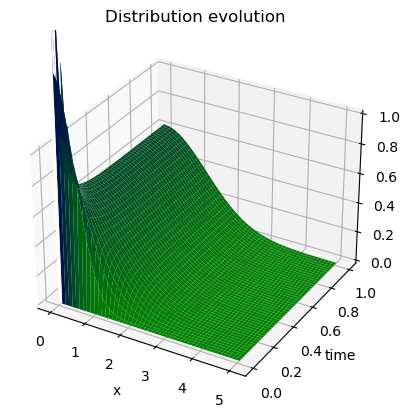

In [15]:
X, Y = np.meshgrid(T_array, x)
density = V

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(Y, X, density, cmap=cm.ocean)
ax.set_title("Distribution evolution")
ax.set_xlabel("x")
ax.set_ylabel("time")
ax.set_zlabel("V")
ax.set_zlim([0, 1])
plt.show()

### Distribution at final time T

In [16]:
distribution = V[:, -1]

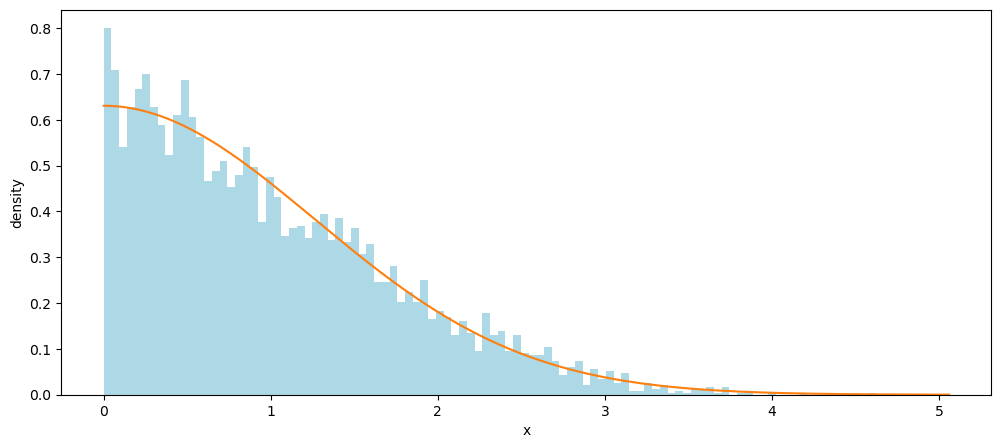

In [17]:
fig = plt.figure(figsize=(12, 5))
plt.hist(X_T, density=True, bins=100, facecolor="LightBlue", label="Frequency of X(T)")
plt.plot(x, distribution)
plt.xlabel("x")
plt.ylabel("density")
plt.show()

##### From the numerical distribution we can compute mean and standard deviation and compare them with theoretical values.

In [18]:
tot_density = np.sum(distribution * dx)
mean_numeric = np.sum(x * distribution * dx)
var_numeric = np.sum(x**2 * distribution * dx) - mean_numeric**2
std_numeric = np.sqrt(var_numeric)

In [19]:
th_mean = sigma / np.sqrt(kappa * np.pi)
th_std = sigma * np.sqrt((1 - 2 / np.pi) / (2 * kappa))

In [20]:
print("Total density={0:.6f}".format(tot_density))
print("Sample values: mean={0:.6f}, STD={1:.6f}".format(mean, std))
print("Parameters from the numerical computation: mean={0:.6f}, STD={1:.6f}".format(mean_numeric, std_numeric))
print(f"Theoretical parameters: mean={th_mean}, std={th_std} ")
print("OU asymptotic std: ", std_asy)

Total density=1.000000
Sample values: mean=1.003902, STD=0.767355
Parameters from the numerical computation: mean=1.008688, STD=0.761802
Theoretical parameters: mean=1.009253008808064, std=0.7625013863671789 
OU asymptotic std:  1.2649110640673518


## Stationary Fokker Plank

The stationary Fokker-Plank equation can be solved analitically.

We set:
$$
\frac{\partial p(t,x)}{\partial t} = 0
$$

and we get:

$$
\kappa \frac{d}{d x} \biggl( 
x \, p(x) \biggr) + \frac{1}{2} \sigma^2 \frac{d^2 p(x)}{d x^2} = 0
\quad \Longrightarrow
$$

$$
\frac{d}{d x} \biggl( \kappa
x \, p(x)  + \frac{1}{2} \sigma^2 \frac{d p(x)}{d x} \biggr) = 0
\quad
\Longrightarrow
\quad
\kappa x \, p(x)  + \frac{1}{2} \sigma^2 \frac{d p(x)}{d x} = const = 0.
$$

This term is constant for every x. So we choose $x=0$:  The first term is zero and the second as well since $p'(0) = 0$. It follows that $const = 0$.

Then we solve the first order ODE by separation of variables.

$$ p(x) = C e^{-\frac{\kappa}{\sigma^2} x^2} $$

C is obtained by imposing that $\int_{0}^{\infty} p(x) dx = 1$.

$$ p(x) = \frac{2}{\sigma} \sqrt{\frac{\kappa}{\pi}} \; e^{-\frac{\kappa}{\sigma^2} x^2}, \quad \quad x\geq 0. $$

This is the [Half Normal distribution](https://en.wikipedia.org/wiki/Half-normal_distribution).

In [21]:
def pdf(x, kappa, sigma):
    """Half Normal distribution"""
    return 2 * np.sqrt(kappa / np.pi) / sigma * np.exp(-(x**2) * kappa / (sigma**2))


def pdf_fit(x, alpha):
    """Fitted half Normal distribution. alpha= kappa/sigma^2"""
    return np.sqrt(2 * alpha / np.pi) * np.exp(-alpha / 2 * x**2)

### MLE half Normal

The half Normal density is:

$$ f(x | \kappa, \sigma) = \sqrt{\frac{2}{\pi}} \sqrt{\frac{2 \kappa}{\sigma^2}} \; e^{-\frac{2 \kappa}{\sigma^2} \frac{x^2}{2} }, \quad \quad x\geq 0. $$

For a set of sample values $x_i$ with $0<i \leq N$ we can define the likely function:

$$ L(\kappa, \sigma | x_1, x_2, ...) = \prod_{i=1}^N \biggl( \frac{2}{\sigma} \sqrt{\frac{\kappa}{\pi}} \biggr) \; e^{-\frac{2 \kappa}{\sigma^2} \frac{x_i^2}{2} } $$

$$ L(\kappa, \sigma | x_1, x_2, ...) = \biggl( \frac{2}{\sigma} \sqrt{\frac{\kappa}{\pi}} \biggr)^N \; e^{- \, \sum_{i=1}^N \, \frac{2 \kappa}{\sigma^2} \frac{x_i^2}{2} } $$

and the log-likelihood. We then take derivatives and check for the maximum point:

$$ l(\kappa, \sigma | x_1, x_2, ...) = -N \log(\frac{\sigma}{2}) + \frac{N}{2} \log(\frac{\kappa}{\pi}) - \frac{\kappa}{\sigma^2} \sum_i x_i^2 $$

Imposing 
$$ \frac{\partial l(\kappa, \sigma)}{\partial \kappa} = 0 \quad \quad \frac{\partial l(\kappa, \sigma)}{\partial \sigma} = 0 $$

we get

$$ \frac{\sigma^2}{2 \kappa} = \frac{1}{N} \sum_{i=1}^N x_i^2 $$

(we can estimate only the ratio, not each single parameter)

In [22]:
# MLE of the single parameter distribution  alpha = 2 k/sigma**2
alpha = 1 / (np.mean(X_T**2))

In [23]:
print("Real alpha: ", 2 * kappa / sigma**2)
print("Estimated alpha: ", alpha)

Real alpha:  0.625
Estimated alpha:  0.6263099649598882


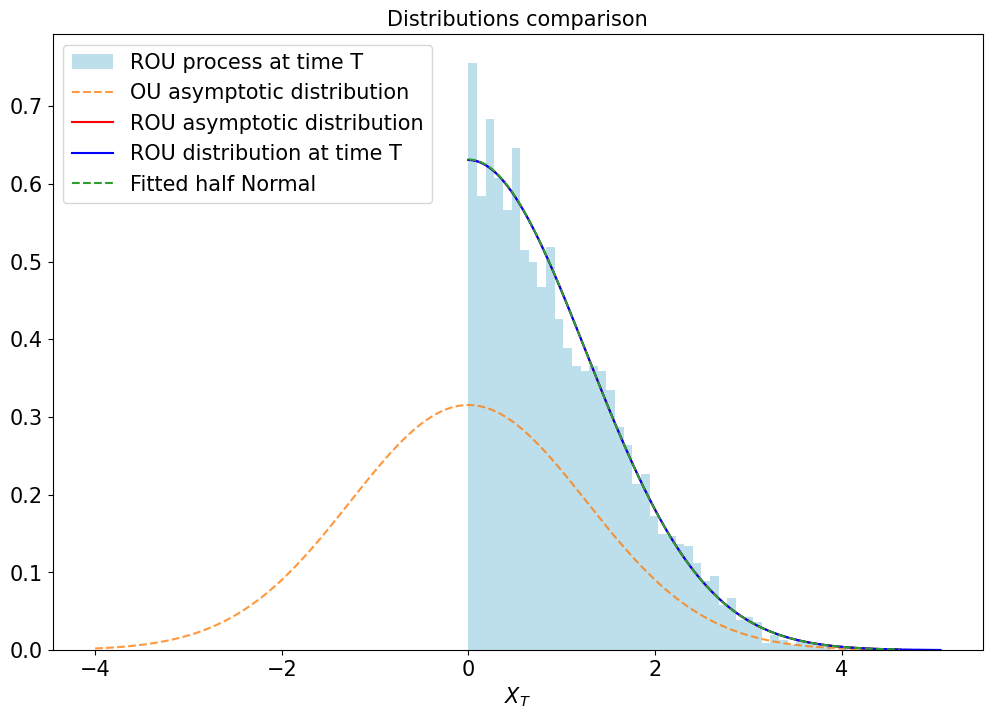

In [24]:
xx = np.linspace(X_T.min(), X_T.max(), 100)
yy = np.linspace(-4, 5, 1000)

fig = plt.figure(figsize=(12, 8))
plt.rcParams.update({"font.size": 15})
plt.hist(X_T, density=True, bins=50, facecolor="LightBlue", alpha=0.8, label="ROU process at time T")
plt.plot(yy, ss.norm.pdf(yy, loc=0, scale=std_asy), linestyle="--", alpha=0.8, label="OU asymptotic distribution")
plt.plot(xx, pdf(xx, kappa, sigma), color="r", label="ROU asymptotic distribution")
plt.plot(x, distribution, color="b", label="ROU distribution at time T")
plt.plot(xx, pdf_fit(xx, alpha), linestyle="--", label="Fitted half Normal")
plt.legend(loc="upper left")
plt.title("Distributions comparison", fontsize=15)
plt.xlabel("$X_T$", fontsize=15)
plt.show()

### References

[1]  Ward A, Glynn P. 
"Properties of the Reflected Ornstein–Uhlenbeck Process". Queueing
Systems: Theory and Applications. 2003;44(2):109–123.

[2]  Uhlenbeck GE, Ornstein LS. 
"On the Theory of the Brownian Motion". Phys Rev.
1930 Sep;36:823–841. Available from: https://link.aps.org/doi/10.1103/PhysRev.36.823.

[3] Chang J.S. Cooper G.
"A Practical Difference Scheme for Fokker-Planck Equations" Journal of computational Physics. (1970) 1-16.